In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, box
import osmnx as ox
import os
from pyproj import CRS
import rasterio
from rasterio import features, plot
from matplotlib import pyplot as plt

In [2]:
#open the cost surface raster
ds = rasterio.open('../data/MIT_Surface_Subset/MIT_CostSurface_500m.img')
band1 = ds.read(1)

In [3]:
#Extract its coordinate reference system
prj = ds.crs

In [4]:
#Read in biogas sources (example: Duplin Co)
dfBG =  pd.read_excel('../data/NC_Biogas_Potential.xlsx',sheet_name='Swine')
#Remove the total row
dfBG = dfBG.loc[dfBG['Facility Name']!='TOTAL']
#Sort values in ascending order by biogas potential
dfBG = dfBG.sort_values(by='Biogas Potential (f^3 / year)',
                        ascending=False).reset_index()

In [5]:
#Convert to geodataframe from lat/lng coordinates
geom = [Point(xy) for xy in zip(dfBG['Longitude'],dfBG['Latitude'])]
gdfBG = gpd.GeoDataFrame(dfBG,geometry=geom,crs=4326)

In [6]:
#Subset points falling in Duplin County
duplin_co = ox.gdf_from_place('Duplin County, NC').unary_union
gdfBG = gdfBG.loc[gdfBG.geometry.within(duplin_co)]

In [7]:
#Project to same crs as raster
gdfBG = gdfBG.to_crs(prj)

In [ ]:
#Subset records intersecting cost surface
bbox = box(*ds.bounds)
gdfBG = gdfBG.loc[gdfBG.geometry.within(bbox)]

In [8]:
#Get x and y offsets for each point
gdfBG['idx'] = gdfBG['geometry'].apply(lambda g: ds.index(g.x,g.y))
gdfBG['xOffset'] = gdfBG['geometry'].apply(lambda g: ds.index(g.x,g.y)[1])
gdfBG['yOffset'] = gdfBG['geometry'].apply(lambda g: ds.index(g.x,g.y)[0])

In [9]:
#Calcuate cost from the index
gdfBG['cost'] =gdfBG['idx'].apply(lambda x: band1[x])

In [10]:
#Drop the index column
gdfBG.drop(columns='idx',inplace=True)
gdfBG.to_file('foo.shp')

In [ ]:
#Create a function to sample points
def get_cost(pt_geom):
    #Get the index
    idx = ds.index(pt_geom.x,pt_geom.y)
    #Get the band value
    band = ds.read(1)
    try:
        value = band[idx]
        return value
    except:
        return -1

In [ ]:
#Apply the function
#gdfBG['cost'] = gdfBG['geometry'].apply(get_cost)

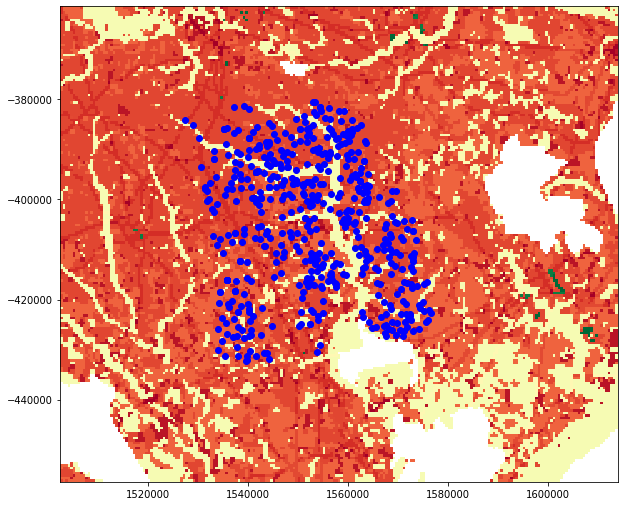

In [11]:
#Plot
fig,ax = plt.subplots(1,1,figsize=(10,10))
plot.show(ds,ax=ax,cmap='RdYlGn')
gdfBG.plot(ax=ax,color='blue')

In [12]:
gdfBG

,index,Facility Name,Address,City,County Name,Zip,Latitude,Longitude,Regulated Activity,Allowable Count,Total Waste (tons / year),Biogas Potential (m^3 / year),Biogas Potential (f^3 / year),geometry,xOffset,yOffset,cost
3,328,Magnolia III DM Section 4 Sites 1-4 Section 3 ...,1114 Beasley Mill Rd,Warsaw,Duplin,28398.0,34.8875,-78.1314,Swine - Feeder to Finish,48520,186392.775915,5.218998e+06,1.843072e+08,POINT (1535780.541 -416033.110),66,109,120
4,345,Magnolia III DM Section 4 Sites 1-4 Section 3 ...,1114 Beasley Mill Rd,Warsaw,Duplin,28398.0,34.8875,-78.1314,Swine - Feeder to Finish,48520,186392.775915,5.218998e+06,1.843072e+08,POINT (1535780.541 -416033.110),66,109,120
6,441,Enviro Tech 1 2 & 3,1049 Sand Ridge Rd,Pink Hill,Duplin,28572.0,35.0144,-77.7839,Swine - Farrow to Wean,10800,143353.811362,4.013907e+06,1.417498e+08,POINT (1562449.489 -396310.978),119,69,200
9,348,DM Farms Sec 2 Sites 1-4,419 Dail Rd,Magnolia,Duplin,28453.0,34.8672,-78.1514,Swine - Feeder to Finish,31680,121700.806698,3.407623e+06,1.203391e+08,POINT (1534522.932 -418579.517),63,114,130
10,330,DM Farms Sec 2 Sites 1-4,419 Dail Rd,Magnolia,Duplin,28453.0,34.8672,-78.1514,Swine - Feeder to Finish,31680,121700.806698,3.407623e+06,1.203391e+08,POINT (1534522.932 -418579.517),63,114,130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2213,613,Floars Sow Farm LLC,229 A B Benson Hog Farm Ln,Kenansville,Duplin,28349.0,35.0339,-77.9381,Swine - Gilts,160,235.383971,6.590751e+03,2.327502e+05,POINT (1548971.565 -396828.693),92,70,120
2219,337,Duplin County Livestock Facility,275 Fairgrounds Dr,Kenansville,Duplin,28349.0,34.9509,-77.9839,Swine - Feeder to Finish,50,192.078293,5.378192e+03,1.899291e+05,POINT (1546907.873 -406635.816),88,90,130
2223,841,Camellia Farms,621 Tom Hill Rd,Faison,Duplin,28341.0,35.1056,-78.1058,Swine - Gilts,120,176.537978,4.943063e+03,1.745627e+05,POINT (1533221.508 -391871.305),61,60,120
2240,334,James W. Dixon Farm,Perry Riverbank Rd,Warsaw,Duplin,28398.0,34.9483,-78.0797,Swine - Feeder to Finish,0,0.000000,0.000000e+00,0.000000e+00,POINT (1538845.780 -408544.141),72,94,120


In [ ]:
#Iterate through all biogas site rows and create a cost distance raster
cost_arrays = [] #Cost arrays
cd_arrays = []   #Cost distance arrays, min cost distance back to source
tb_arrays = []   #Traceback arrays, for creating the least cost path

for i,r in gdfBG.iterrows():
    xOffset = r['xOffset']    #get the array x coordinate of the biogas source
    yOffset = r['yOffset']    #get the array y coordinate of the biogas soruce
    z = r['cost'] / 1609.34   #Get the pipeline cost (5th col) & convert from $/mile to $/meter
    base_cost = r[3]          #Get the base production cost (4th col)
    
    #Create the minimum cost path (MCP) surface, setting the distance between pixels to cell sizes
    lc_graph = graph.MCP_Geometric(arrCost * z , sampling=(x_size,y_size))
    #Compute cost distances away from the biogas source coordinates
    cd_array,tb_array = lc_graph.find_costs(starts=([(yOffset, xOffset)]))
    #Add the initial cost to all cells
    cd_array = cd_array + base_cost
    #Add to stack of arrays
    cost_arrays.append(arrCost * z)
    cd_arrays.append(cd_array)
    tb_arrays.append(tb_array)
        
#Create a stack of all arrays
arrCostStack = np.stack(cost_arrays)
arrCostDistanceStack =np.stack(cd_arrays)
arrTracebackStack = np.stack(tb_arrays)

#Save the array stacks to file
np.save('../data/DuplinCostStack.npy',arrCostStack)
np.save('../data/DuplinStack.npy',arrCostDistanceStack)
np.save('../data/DuplinTraceStack.npy',arrTracebackStack)